# Modularized Overbooking Program

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import binom, skew, kurtosis
import seaborn as sns
import itertools

## Initialize the Parameters

In [2]:
# MODIFIABLE
def probability_multiplier(t):
    return 0.75 + t/730 # Modify what the function is   

params = {
    'priceL_coach': 300, # Low price of coach
    'priceH_coach': 350, # High price of coach
    'priceL_first': 425, # Low price of first class
    'priceH_first': 500, # High price of first class
    'pL_coach': [0.35,0.65], # Probability for low price coach: 0 is no buy, 1 is buy
    'pH_coach': [0.7,0.3], # Probability for high price coach: 0 is no buy, 1 is buy
    'prob_adder': 0.03, # Additional probability for buying coach given first class is booked
    'pL_first': [0.92,0.08], # Probability for low price first class: 0 is no buy, 1 is buy
    'pH_first': [0.96,0.04], # Probability for high price first class: 0 is no buy, 1 is buy
    'delta': 1/(1+0.17/365), # Discount rate per day
    'C': 100, # Number of coach seats
    'F': 20, # Number of first class seats
    'T': 365, # Number of days to sell tickets
    'fc_passenger_show': 0.97, # Probability of first class passenger showing up
    'coach_passenger_show': 0.95, # Probability of coach passenger showing up
    'throw_out_coach': 425, # Price to pay to throw out of coach
    'upgrade_fc': 50, # Price to pay to bump up to first class
}

## Overbooking Class

In [ ]:
class OverbookingProblem:
    def __init__(self, kwargs): # Take a list of arguments and then pass them
        self.priceL_coach = kwargs['priceL_coach']
        self.priceH_coach = kwargs['priceH_coach']
        self.priceL_first = kwargs['priceL_first']
        self.priceH_first = kwargs['priceH_first']
        self.pL_coach = kwargs['pL_coach']
        self.pH_coach = kwargs['pH_coach']
        self.pL_coach_updated = [kwargs['pL_coach'][0] - kwargs['prob_adder'], kwargs['pL_coach'][1] + kwargs['prob_adder']]
        self.pH_coach_updated = [kwargs['pH_coach'][0] - kwargs['prob_adder'], kwargs['pH_coach'][1] + kwargs['prob_adder']]
        self.prob_adder = kwargs['prob_adder']
        self.pL_first = kwargs['pL_first']
        self.pH_first = kwargs['pH_first']
        self.delta = kwargs['delta']
        self.C = kwargs['C']
        self.F = kwargs['F']
        self.T = kwargs['T']
        self.fc_passenger_show = kwargs['fc_passenger_show']
        self.coach_passenger_show = kwargs['coach_passenger_show']
        self.throw_out_coach = kwargs['throw_out_coach']
        self.upgrade_fc = kwargs['upgrade_fc']
        
    # Function will set up the array given a value of overbooking
    def set_up_overbooking_array(self, overbooking):
        cValues = np.arange(self.C+overbooking+1) # all possible number of coach seats left (start with overbooking just 5)
        fValues = np.arange(self.F+1) # all possible number of first class seats left (cannot overbook first class)
        tValues = np.arange(self.T+1) # all possible days until takeoff

        cN = len(cValues) # count possible state values
        fN = len(fValues) # count possible state values
        tN = len(tValues) # Time values

        V = np.zeros((cN,fN,tN)) # initialize value function
        Uc = np.zeros((cN,fN,tN)) # initialize optimal choice variable
        Uf = np.zeros((cN,fN,tN)) # initialize optimal choice variable
        
        return V, Uc, Uf, cN, fN, tN
    
    # Function that will update the probabilities with the probability multiplier
    def apply_prob_multiplier(self, prob_mp):
        pL_coach = [(1-self.pL_coach[1]*prob_mp), self.pL_coach[1]*prob_mp]
        pH_coach = [(1-self.pH_coach[1]*prob_mp), self.pH_coach[1]*prob_mp]
        pL_coach_updated = [(1-self.pL_coach[1]*prob_mp-self.prob_adder), self.pL_coach[1]*prob_mp+self.prob_adder]
        pH_coach_updated = [(1-self.pH_coach[1]*prob_mp-self.prob_adder), self.pH_coach[1]*prob_mp+self.prob_adder]
        pL_first = [(1-self.pL_first[1]*prob_mp), self.pL_first[1]*prob_mp]
        pH_first = [(1-self.pH_first[1]*prob_mp), self.pH_first[1]*prob_mp]
        return pL_coach, pH_coach, pL_coach_updated, pH_coach_updated, pL_first, pH_first
    
    # Function that runs the overbooking policy based on three potential coach scenarios and two first class scenarios
    def overbooking_dp(self, overbooking, prob_mp, no_coach_policy, seasonality):
        '''
        Inputs:
            overbooking: The number of seats you wish to overbook coach by
            prob_mp: The probability multiplier (as a function of t)
            no_coach_policy: 0 doesn't have choice of setting coach demand to 0 on given day, 1 has the choice of forcing coach demand to 0 on given day
            seasonality: 0 for no seasonality, 1 for seasonality
        Outputs:
            V: Updated value array
            Uc: Updated optimal coach choices 
            Uf: Updated optimal fc choices 
        '''
        # First get the arrays
        V, Uc, Uf, cN, fN, tN = self.set_up_overbooking_array(overbooking)    
        
        # Set up the terminal condition. For time 365, no revenue is made but there are still costs.
        # Loop over every possible combination of coach and first class at time 365, in terms of tickets sold
        for c in range(cN-overbooking, cN): # The value is always 0 if you sold 100 coach or less (no costs)
            for f in range(fN): # Number of tickets being sold
                # For each set of coach and first class sold, we then must calculate the cost of kicking people out or bumping them up
                # Note that for coach, once again, if 100 or less people show up, there aren't any costs                
                for c2 in range(self.C+1, c+1): # How many people might end up showing up in coach? Again, if 100 or less people show up, no costs
                    for f2 in range(f+1): # iterate over all possible first class people that could show up
                        if self.F - f2 >= c2 - self.C: # If there are more available seats in fc than there are overbooked, then the cost is just bump passengers up
                            V[c, f, tN-1] += -self.upgrade_fc*(c2-self.C)*(binom.pmf(c2, c, self.coach_passenger_show)* \
                                binom.pmf(f2, f, self.fc_passenger_show))
                        else: # You will have to toss some people out of coach
                            V[c, f, tN-1] += (-self.upgrade_fc*(self.F-f2) - self.throw_out_coach*((c2-self.C)-(self.F-f2))) * \
                                (binom.pmf(c2, c, self.coach_passenger_show)*binom.pmf(f2, f, self.fc_passenger_show))
                        
                        Uc[c, f, tN-1] = 0 # 0 for coach represents no tickets sold
                        Uf[c, f, tN-1] = 0 # 0 for first class represents no tickets sold
        
        # Main body of the problem
        for t in reversed(range(tN-1)): # Iterate over 0-364
            # Here, get the updated probabilities based on the probability multiplier
            # if seasonality is enabled
            pL_coach, pH_coach, pL_coach_updated, pH_coach_updated, pL_first, pH_first = self.apply_prob_multiplier(prob_mp(t)) \
                if seasonality else self.apply_prob_multiplier(1)
            
            for c in range(cN): # Iterate over coach seats
                for f in range(fN): # Iterate over first class seats
                    
                    # If both first class and coach are both booked out, no more tickets can be sold
                    if f == self.F and c == self.C + overbooking:
                        V[c, f, t] = self.delta*V[c, f, t+1] # if so, you can't make any more money
                        Uc[c, f, t] = 0
                        Uf[c, f, t] = 0
                    # If first class is completely booked out, update the coach probabilities, also cannot book anymore first class
                    elif f == self.F and c < self.C + overbooking:                       
                        # Scenario 1: Low coach
                        valueLC = pL_coach_updated[1]*self.priceL_coach + self.delta* (pL_coach_updated[0]*V[c,f,t+1] + \
                            pL_coach_updated[1]*V[c+1,f,t+1])
                        
                        # Scenario 2: High coach
                        valueHC = pH_coach_updated[1]*self.priceH_coach + self.delta* (pH_coach_updated[0]*V[c,f,t+1] + \
                            pH_coach_updated[1]*V[c+1,f,t+1])
                        
                        # If policy is to drive coach demand to 0
                        # Scenario 3: No coach
                        valueNC = 0 + self.delta* V[c,f,t+1] if no_coach_policy else -np.inf

                        V[c, f, t] = max(valueNC, valueLC, valueHC) # value function maximizes expected revenue
                        Uc[c, f, t] = np.argmax([valueNC, valueLC, valueHC]) 
                        Uf[c, f, t] = 0
                    # If coach is completely booked out and first class is not fully booked out
                    elif f < self.F and c == self.C + overbooking:                  
                        # Scenario 1: Low first class
                        valueLF = pL_first[1]*self.priceL_first + self.delta* (pL_first[0]*V[c,f,t+1] + pL_first[1]*V[c,f+1,t+1])
                        
                        # Scenario 2: High first class
                        valueHF = pH_first[1]*self.priceH_first + self.delta* (pH_first[0]*V[c,f,t+1] + pH_first[1]*V[c,f+1,t+1])
                        
                        V[c,f,t] = max(valueLF,valueHF) # value funciton maximizes expected revenue
                        Uf[c, f, t] = np.argmax([valueLF, valueHF]) + 1
                        Uc[c, f, t] = 0
                    # If coach and first class are both not fully booked out
                    else:                
                        # Scenario 1: Low coach, low first class
                        valueLCLF = pL_coach[1]*self.priceL_coach + pL_first[1]*self.priceL_first + \
                            self.delta* (pL_coach[0]*pL_first[0]*V[c,f,t+1] + pL_coach[1]*pL_first[0]*V[c+1,f,t+1] + \
                                pL_coach[0]*pL_first[1]*V[c,f+1,t+1] + pL_coach[1]*pL_first[1]*V[c+1,f+1,t+1])
                        
                        # Scenario 2: High coach, low first class
                        valueHCLF = pH_coach[1]*self.priceH_coach + pL_first[1]*self.priceL_first + \
                            self.delta* (pH_coach[0]*pL_first[0]*V[c,f,t+1] + pH_coach[1]*pL_first[0]*V[c+1,f,t+1] + \
                                pH_coach[0]*pL_first[1]*V[c,f+1,t+1] + pH_coach[1]*pL_first[1]*V[c+1,f+1,t+1])
                        
                        # Scenario 3: High coach, high first class
                        valueHCHF = pH_coach[1]*self.priceH_coach + pH_first[1]*self.priceH_first + \
                            self.delta* (pH_coach[0]*pH_first[0]*V[c,f,t+1] + pH_coach[1]*pH_first[0]*V[c+1,f,t+1] + \
                                pH_coach[0]*pH_first[1]*V[c,f+1,t+1] + pH_coach[1]*pH_first[1]*V[c+1,f+1,t+1])
                        
                        # Scenario 4: Low coach, high first class
                        valueLCHF = pL_coach[1]*self.priceL_coach + pH_first[1]*self.priceH_first + \
                            self.delta* (pL_coach[0]*pH_first[0]*V[c,f,t+1] + pL_coach[1]*pH_first[0]*V[c+1,f,t+1] + \
                                pL_coach[0]*pH_first[1]*V[c,f+1,t+1] + pL_coach[1]*pH_first[1]*V[c+1,f+1,t+1])

                        if no_coach_policy:
                            # Scenario 5: No coach, low first class
                            valueNCLF = pL_first[1]*self.priceL_first + self.delta* (pL_first[1]*V[c,f+1,t+1] + pL_first[0]*V[c,f,t+1])
                            
                            # Scenario 6: No coach, high first class
                            valueNCHF = pH_first[1]*self.priceH_first + self.delta* (pH_first[1]*V[c,f+1,t+1] + pH_first[0]*V[c,f,t+1])
                        else:
                            valueNCLF = -np.inf
                            valueNCHF = -np.inf
                        
                        # Get best value
                        V[c,f,t] = max(valueLCLF, valueHCLF, valueHCHF, valueLCHF, valueNCLF, valueNCHF) # value funciton maximizes expected revenue
                        
                        # Choices: 
                        best_choice = np.argmax([valueLCLF, valueHCLF, valueHCHF, valueLCHF, valueNCLF, valueNCHF]) + 1 
                        
                        if best_choice == 1:
                            Uc[c,f,t] = 1 # low
                            Uf[c,f,t] = 1
                        elif best_choice == 2:
                            Uc[c,f,t] = 2 # high
                            Uf[c,f,t] = 1
                        elif best_choice == 3:
                            Uc[c,f,t] = 2
                            Uf[c,f,t] = 2
                        elif best_choice == 4:
                            Uc[c,f,t] = 1
                            Uf[c,f,t] = 2
                        elif best_choice == 5:
                            Uc[c,f,t] = 0
                            Uf[c,f,t] = 1
                        elif best_choice == 6:
                            Uc[c,f,t] = 0
                            Uf[c,f,t] = 2
                            
        return V, Uc, Uf
    
    # Helper function to get result based on probability
    def get_prob(self, probability_success, outcomes):
        # First get a random number between 0-1
        rand_num = random.random()
        
        # If that random number is within the desired probability
        if rand_num <= probability_success:
            return outcomes[1] # Assume index 1 is a success
        else:
            return outcomes[0]
    
    def simulate_overbooking_policy(self, overbooking, prob_mp, seasonality, Uc, Uf):
        '''
        Simulates the ticket selling given set of policies over a number of days
        Inputs:
            overbooking: The number of seats you wish to overbook coach by
            prob_mp: The probability multiplier (as a function of t)
            no_coach_policy: 0 doesn't have choice of setting coach demand to 0 on given day, 1 has the choice of forcing coach demand to 0 on given day
            seasonality: 0 for no seasonality, 1 for seasonality
        Outputs: dict with following key-value pairs
            rev: resulting revenue
            overbooked: 0 if not overbooked, 1 if overbooked
            kicked_off: 0 if no passengers kicked off, 1 if passengers are kicked off
        '''
        # Keep track of number of coach and first class sold
        first_class_tickets_sold, coach_tickets_sold = 0, 0
        revenue = 0 # how much you made in revenue for first class and coach
        for t in range(0, self.T): # Iterate over (0-364)
            if seasonality: # if seasonality is enabled
                pL_coach, pH_coach, pL_coach_updated, pH_coach_updated, pL_first, pH_first = self.apply_prob_multiplier(prob_mp(t))
            else:
                pL_coach, pH_coach, pL_coach_updated, pH_coach_updated, pL_first, pH_first = self.apply_prob_multiplier(1)
            
            # First check if you reached maximum # tickets sold in both fc, coach
            if first_class_tickets_sold == self.F and coach_tickets_sold == self.C + overbooking:
                break # break if max is reached on both
            # Check if you are sold out of first class but not coach
            elif first_class_tickets_sold == self.F and coach_tickets_sold < self.C + overbooking:
                # Then you must use updated coach probabilities                
                # Determine what choice was made for coach
                coach_choice = Uc[0, 0, t] if t == 0 else Uc[coach_tickets_sold, first_class_tickets_sold, t]
                                
                # Check what the coach choice was
                coach_ticket_sell = self.get_prob(pL_coach_updated[1] if coach_choice == 1 else (pH_coach_updated[1] if coach_choice == 2 else 0), [0, 1])
                    
                # Update revenue
                revenue += (self.priceL_coach if coach_choice == 1 else (self.priceH_coach if coach_choice == 2 else 0))*coach_ticket_sell*self.delta**t
    
                # Update the number of tickets sold
                coach_tickets_sold += coach_ticket_sell
            # Coach is fully sold out, but first class is not
            elif first_class_tickets_sold < self.F and coach_tickets_sold == self.C + overbooking:                
                # Determine what choice was made for coach
                fc_choice = Uf[0, 0, t] if t == 0 else Uf[coach_tickets_sold, first_class_tickets_sold, t]
                
                # Check what the first class choice was
                fc_ticket_sell = self.get_prob(pL_first[1] if fc_choice == 1 else (pH_first[1] if fc_choice == 2 else 0), [0, 1])
                
                # Update revenue
                revenue += (self.priceL_first if fc_choice == 1 else (self.priceH_first if fc_choice == 2 else 0))*fc_ticket_sell*self.delta**t
                
                # Update the number of tickets sold
                first_class_tickets_sold += fc_ticket_sell
            # Still can buy both coach or first class
            else:
                # Determine whether you buy a ticket or not
                # Determine what choice was made for coach, first class
                coach_choice = Uc[0, 0, t] if t == 0 else Uc[coach_tickets_sold, first_class_tickets_sold, t]
                fc_choice = Uf[0, 0, t] if t == 0 else Uf[coach_tickets_sold, first_class_tickets_sold, t]
                
                # Check what the coach choice was
                coach_ticket_sell = np.random.random() < pL_coach[1] if coach_choice == 1 else (np.random.random() < pH_coach[1] if coach_choice == 2 else 0)
                
                # Check what the first class choice was
                fc_ticket_sell = np.random.random() < pL_first[1] if fc_choice == 1 else (np.random.random() <  pH_first[1] if fc_choice == 2 else 0)
                    
                # Update the number of tickets sold
                first_class_tickets_sold += fc_ticket_sell
                coach_tickets_sold += coach_ticket_sell
                
                # Update revenue
                revenue += ((self.priceL_coach if coach_choice == 1 else (self.priceH_coach if coach_choice == 2 else 0))*coach_ticket_sell*self.delta**t + \
                    (self.priceL_first if fc_choice == 1 else (self.priceH_first if fc_choice == 2 else 0))*fc_ticket_sell*self.delta**t)
        
        # Now check day 365 and determine what costs must be paid out
        # First we must determine how many people will show up in each 
        num_people_coach, num_people_first = 0, 0
        for _ in range(coach_tickets_sold):
            coach_show_up = np.random.random() < self.coach_passenger_show
            num_people_coach += coach_show_up
            
        for _ in range(first_class_tickets_sold):
            fc_show_up = np.random.random() < self.fc_passenger_show
            num_people_first += fc_show_up
        
        # Now determine what overbooking costs we must incur
        overbooking_cost = 0
        if num_people_coach > self.C:
            if num_people_coach - self.C <= self.F - num_people_first: # More open seats in first class than there are overbooked coach
                overbooking_cost = (self.upgrade_fc*(num_people_coach-self.C)) 
            else:
                overbooking_cost = (self.upgrade_fc*(num_people_first-self.F)) + (self.throw_out_coach*((num_people_coach-self.C) - (self.F-num_people_first)))
            revenue -= overbooking_cost
        
        sim_dict = {
            'rev': revenue, 
            'overbooked': num_people_coach > self.C,
            'kicked_off': num_people_coach - self.C > self.F - num_people_first,
            'overbooking_cost': overbooking_cost         
            }
        
        return sim_dict
    
    def run_simulations(self, nsims, overbooking, seasonality, no_coach_policy, probability_multiplier, print_graphs):
        '''
        Will run simulations on flight booking problem depending on the policy
        Inputs:
            nsims: How many simulations to run
            overbooking: How many coach seats will you allow overbooked
            seasonality: 0 for no seasonality, 1 for seasonality
            no_coach_policy: 0 for not driving coach demand to 0, 1 for driving coach demand to 0
            probability_multiplier: prob_multiplier function
            print_graphs: 1 to show graphs, 0 to not
        Outputs:
            Results from simulation, including graphs
        '''
        # For the print statement
        text = 'forcing coach seat demand to 0' if no_coach_policy else 'no forcing coach seat demand to 0'
        text0 = 'Seasonality' if seasonality else 'No seasonality'
        
        print("="*100)
        print(f"Overbooking {overbooking} coach seats. {text0} policy and {text}.")
        print(f"Price of Low Coach: {self.priceL_coach}. Price of High Coach: {self.priceH_coach}.")
        print(f"Price of Low First Class: {self.priceL_first}. Price of High First Class: {self.priceH_first}.")
        print(f"Probability of buying low coach: {self.pL_coach[1]*100:.4f}%. Probability of buying high coach: {self.pH_coach[1]*100:.4f}%" )
        print(f"Probability of buying low first class: {self.pL_first[1]*100:.4f}%. Probability of buying high first class: {self.pH_first[1]*100:.4f}%" )
        print(f"Running {nsims} simulations...")
        print("-"*100)
        
        # Perform simulations
        revenues, overbooked, kicked_off, overbooking_cost = [], [], [], []
        V, Uc, Uf = self.overbooking_dp(overbooking=overbooking, prob_mp=probability_multiplier, 
                                                       no_coach_policy=no_coach_policy, seasonality=seasonality)
        for _ in range(nsims):
            sims_dict = self.simulate_overbooking_policy(overbooking=overbooking, prob_mp=probability_multiplier, 
                                                                        seasonality=seasonality, Uc=Uc, Uf=Uf)
            revenues.append(sims_dict['rev'])
            overbooked.append(sims_dict['overbooked'])
            overbooking_cost.append(sims_dict['overbooking_cost'])
            kicked_off.append(sims_dict['kicked_off'])

        # Print results
        print(f'Overbooked in {(np.mean(overbooked) * 100):.4f}% of simulations.')
        print(f'Average Overbooking Cost: ${np.mean(overbooking_cost):.4f}')
        print(f'Passengers kicked off coach in {(np.mean(kicked_off) * 100):.4f}% of simulations.')
        print(f'Average Profit: ${np.mean(revenues):.4f}')
        print(f'Expected Profit from Dynamic Programming: ${V[0, 0, 0]:.4f}')
        print(f'Standard Deviation of Profit: ${np.std(revenues):.2f}')
        print(f'Skewness of Profit: {skew(revenues):.4f}')
        print(f'Kurtosis of Profit: {kurtosis(revenues):.4f}')
        print("="*100)
        print("\n")
        
        if print_graphs:
            print("Graphs of the results: ")
            print("-"*100)
            _, ax = plt.subplots(2, 3, figsize=(15, 10))
            sns.histplot(revenues, ax=ax[0][0], color='black')
            ymin, ymax = ax[0][0].get_ylim()
            ax[0][0].set_title('Histogram of Simulated Profit')
            ax[0][0].vlines(np.mean(revenues) + np.std(revenues), 0, ymax, colors='red')
            ax[0][0].vlines(np.mean(revenues) - np.std(revenues), 0, ymax, colors='red')
            ax[0][0].vlines(V[0, 0, 0], 0, ymax, colors='green')

            # Overbooked
            overbooked_counts = [0 if not v else 1 for v in overbooked]
            overbooked_df = pd.DataFrame([("No", len(overbooked_counts) - sum(overbooked_counts)), ("Yes", sum(overbooked_counts))])
            overbooked_df = overbooked_df.set_index(0).T
            sns.barplot(overbooked_df, ax=ax[0][1])
            ax[0][1].set_xlabel('Coach Overbooked')
            ax[0][1].set_ylabel('Frequency')
            ax[0][1].set_title('Frequency of Overbooked Flights')

            # Kicked off coach
            kicked_off_counts = [0 if not v else 1 for v in kicked_off]
            kicked_off_df = pd.DataFrame([("No", len(kicked_off_counts) - sum(kicked_off_counts)), ("Yes", sum(kicked_off_counts))])
            kicked_off_df = kicked_off_df.set_index(0).T
            sns.barplot(kicked_off_df, ax=ax[0][2])
            ax[0][2].set_xlabel('Passengers Kicked off Coach')
            ax[0][2].set_ylabel('Frequency')
            ax[0][2].set_title('Frequency of Passengers Kicked off Coach')
            
            # Overbooking Cost
            sns.histplot(overbooking_cost, ax=ax[1][0], color='black')
            ax[1][0].set_title('Histogram of Simulated Overbooking Costs')
            
            ax[1,1].set_axis_off()
            ax[1,2].set_axis_off()
        
        return Uc, Uf
    
    # Modifies an existing attribute value
    def modify_parameters(self, **kwargs):
        for (ky, val) in kwargs.items():
            setattr(self, ky, val)
    
    # Have a function that resets all attributes to the originally defined ones
    def reset_to_original(self, kwargs):
        self.priceL_coach = kwargs['priceL_coach']
        self.priceH_coach = kwargs['priceH_coach']
        self.priceL_first = kwargs['priceL_first']
        self.priceH_first = kwargs['priceH_first']
        self.pL_coach = kwargs['pL_coach']
        self.pH_coach = kwargs['pH_coach']
        self.pL_coach_updated = [kwargs['pL_coach'][0] - kwargs['prob_adder'], kwargs['pL_coach'][1] + kwargs['prob_adder']]
        self.pH_coach_updated = [kwargs['pH_coach'][0] - kwargs['prob_adder'], kwargs['pH_coach'][1] + kwargs['prob_adder']]
        self.pL_first = kwargs['pL_first']
        self.pH_first = kwargs['pH_first']
        self.delta = kwargs['delta']
        self.C = kwargs['C']
        self.F = kwargs['F']
        self.T = kwargs['T']
        self.fc_passenger_show = kwargs['fc_passenger_show']
        self.coach_passenger_show = kwargs['coach_passenger_show']
        self.throw_out_coach = kwargs['throw_out_coach']
        self.upgrade_fc = kwargs['upgrade_fc']

# Initialize the class with the parameters
overbooking_session = OverbookingProblem(params)

## Question 1: No Seasonality and No Forcing Coach Demand to 0

In [ ]:
V, _, _ = overbooking_session.overbooking_dp(overbooking=5, prob_mp=probability_multiplier, no_coach_policy=0, seasonality=0)

print(f"Value when overbooking 5 seats with no seasonality and no option to force coach demand to 0: ${V[0, 0, 0]:.4f}")

Value when overbooking 5 seats with no seasonality and no option to force coach demand to 0: $41886.16


## Question 2: Best Overbooking Policy

In [ ]:
overbooking_vals = list(range(6, 16))
vals = []
for overbooking in overbooking_vals:
    V, _, _ = overbooking_session.overbooking_dp(overbooking=overbooking, prob_mp=probability_multiplier, no_coach_policy=0, seasonality=0)
    vals.append(V[0,0,0])

print(f"Best overbooking policy: {overbooking_vals[np.argmax(vals)]} coach seats with a profit of ${np.max(vals):.4f}.")

Best overbooking policy: 9 coach seats with a profit of $42134.62.


## Question 3: No Coach Policy

In [ ]:
overbooking = 20

V, _, _ = overbooking_session.overbooking_dp(overbooking=overbooking, prob_mp=probability_multiplier, no_coach_policy=1, seasonality=0)
print(f'Overbooking Policy of {overbooking} coach seats with forcing coach demand to 0: ${V[0, 0, 0]:.4f}')

Overbooking Policy of 20 coach seats with forcing coach demand to 0: $42139.89


## Question 4: Seasonality

In [ ]:
overbooking = 20

V, _, _ = overbooking_session.overbooking_dp(overbooking=overbooking, prob_mp=probability_multiplier, no_coach_policy=1, seasonality=1)
print(f'Overbooking Policy of {overbooking} coach seats with seasonality and forcing coach demand to 0: ${V[0, 0, 0]:4f}')
print('---------------------------------------------------------------------------------------------------------')

V, _, _ = overbooking_session.overbooking_dp(overbooking=overbooking, prob_mp=probability_multiplier, no_coach_policy=0, seasonality=1)
print(f'Overbooking Policy of {overbooking} coach seats with seasonality and not forcing coach demand to 0: ${V[0, 0, 0]:4f}')

Overbooking Policy of 20 coach seats with seasonality and forcing coach demand to 0: $41826.44687221107
---------------------------------------------------------------------------------------------------------
Overbooking Policy of 20 coach seats with seasonality and not forcing coach demand to 0: $41718.65026398371


## Question 5: Simulation

Overbooking 20 coach seats. Seasonality policy and forcing coach seat demand to 0.
Price of Low Coach: 300. Price of High Coach: 350.
Price of Low First Class: 425. Price of High First Class: 500.
Probability of buying low coach: 65.00%. Probability of buying high coach: 30.00%
Probability of buying low first class: 8.00%. Probability of buying high first class: 4.00%
Running 10000 simulations...
----------------------------------------------------------------------------------------------------
Overbooked in 81.85% of simulations.
Average Overbooking Cost: $939.59
Passengers kicked off coach in 70.58% of simulations.
Average Profit: $41733.68
Expected Profit from Dynamic Programming: $41826.45
Standard Deviation of Profit: $984.45
Skewness of Profit: -0.13
Kurtosis of Profit: -0.21


Graphs of the results: 
----------------------------------------------------------------------------------------------------


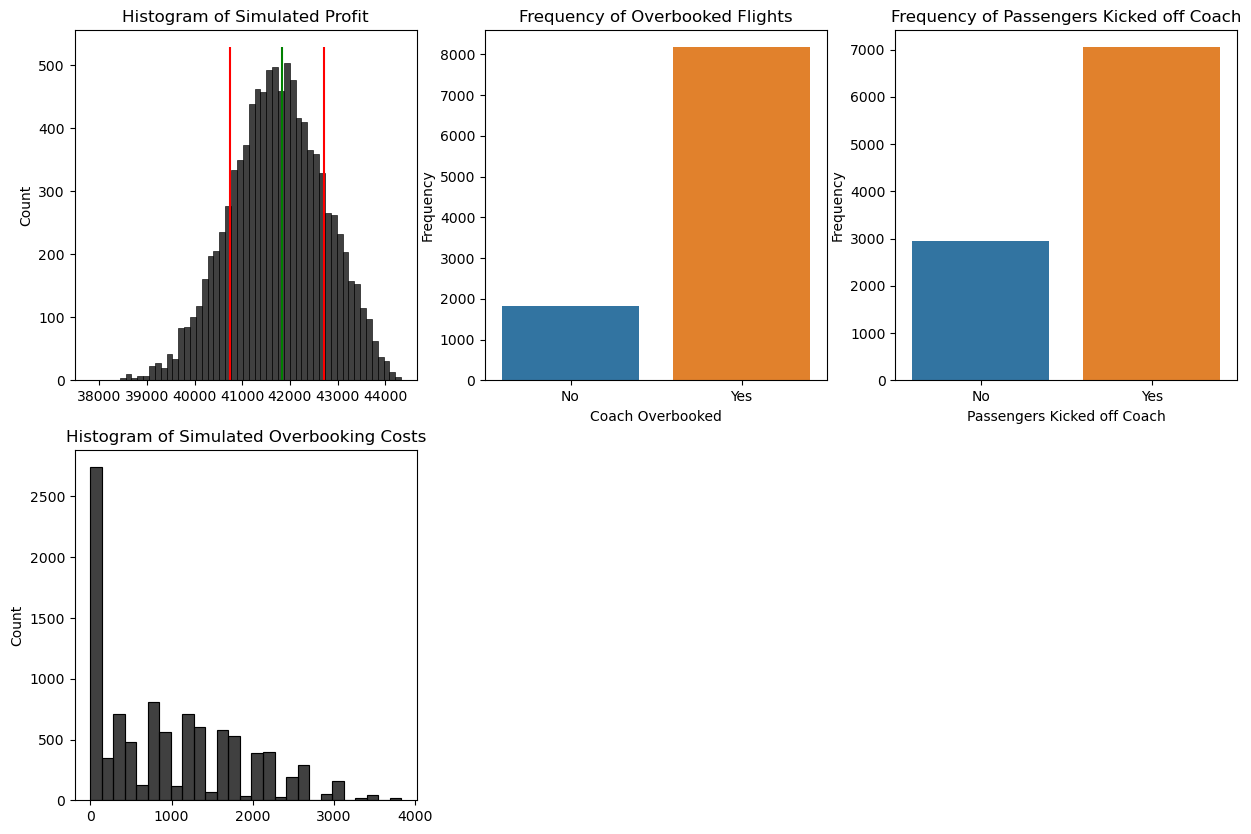

In [17]:
# Changable parameters
nsims = 10000
ob = 20
seasonality = 1
no_coach_policy = 1
print_graphs = 1

Uc, Uf = overbooking_session.run_simulations(nsims, ob, seasonality, no_coach_policy, probability_multiplier, print_graphs)

## Bonus

### Additional Question 1:

What happens if we adjust the price difference in coach between low and high?

In [123]:
# Changable parameters
nsims = 2000
ob = 20
seasonality = 0
no_coach_policy = 0
print_graphs = 0
priceL_coach = 300
priceH_coach = [priceL_coach + 50*i for i in range(1, 5)]

for priceH in priceH_coach:
    overbooking_session.modify_parameters(priceH_coach=priceH) # First modify
    
    # Run simulations
    overbooking_session.run_simulations(nsims, ob, seasonality, no_coach_policy, probability_multiplier, print_graphs)

# Reset back
overbooking_session.reset_to_original(params)

Overbooking 20 coach seats. No seasonality policy and no forcing coach seat demand to 0.
Price of Low Coach: 300. Price of High Coach: 350.
Price of Low First Class: 425. Price of High First Class: 500.
Probability of buying low coach: 65.00%. Probability of buying high coach: 30.00%
Probability of buying low first class: 8.00%. Probability of buying high first class: 4.00%
Running 2000 simulations...
----------------------------------------------------------------------------------------------------
Overbooked in 86.25% of simulations.
Average Overbooking Cost: $3141.84
Passengers kicked off coach in 90.05% of simulations.
Average Profit: $40742.62
Expected Profit from Dynamic Programming: $42028.74
Standard Deviation of Profit: $1547.69
Skewness of Profit: -0.67
Kurtosis of Profit: 0.76


Overbooking 20 coach seats. No seasonality policy and no forcing coach seat demand to 0.
Price of Low Coach: 300. Price of High Coach: 400.
Price of Low First Class: 425. Price of High First Class: 

### Additional Question 2:

What happens if the probability of selling a first class ticket is changed?

In [125]:
# Changable parameters
nsims = 2000
ob = 20
seasonality = 0
no_coach_policy = 0
print_graphs = 0
fc_probL, fc_probH = overbooking_session.pL_first, overbooking_session.pH_first

prob_mods = [0.03, 0.05, 0.07, 0.09]

for prob in prob_mods:
    
    overbooking_session.modify_parameters(pL_first=[fc_probL[0]-prob, fc_probL[1]+prob], 
                                          pH_first=[fc_probH[0]-prob, fc_probH[1]+prob]) # First modify
    
    # Run simulations
    overbooking_session.run_simulations(nsims, ob, seasonality, no_coach_policy, probability_multiplier, print_graphs)

# Reset back
overbooking_session.reset_to_original(params)

Overbooking 20 coach seats. No seasonality policy and no forcing coach seat demand to 0.
Price of Low Coach: 300. Price of High Coach: 350.
Price of Low First Class: 425. Price of High First Class: 500.
Probability of buying low coach: 65.00%. Probability of buying high coach: 30.00%
Probability of buying low first class: 11.00%. Probability of buying high first class: 7.00%
Running 2000 simulations...
----------------------------------------------------------------------------------------------------
Overbooked in 87.10% of simulations.
Average Overbooking Cost: $3287.69
Passengers kicked off coach in 90.00% of simulations.
Average Profit: $42041.80
Expected Profit from Dynamic Programming: $42978.61
Standard Deviation of Profit: $1221.53
Skewness of Profit: -0.89
Kurtosis of Profit: 2.76


Overbooking 20 coach seats. No seasonality policy and no forcing coach seat demand to 0.
Price of Low Coach: 300. Price of High Coach: 350.
Price of Low First Class: 425. Price of High First Class: